Let's set up the problem first:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import companion

In [2]:
# Convenience function to construct intersecting sinusoidal stack described in the paper
def intersecting_cosine_curves(x):
    y1 = np.sin(x)
    y2 = np.cos(2*x)
    y3 = np.sin(2*x)
    y4 = 1/3+np.cos(2*x/3)
    return y1, y2, y3, y4

Next we define the sampling and generate the sorted stack. We generate $L$ uniformly distributed points on an interval $(a,b)$ then sort them.

In [3]:
# Generate x values
a = 0
b = 2
L = 4000 # Sample number can be played with as well
np.random.seed(42) # make things reproducible
x_values = np.sort(np.random.uniform(a,b,L))  # uniformly distributed random samples

# Construct sinusoidal curves
y1_values, y2_values, y3_values, y4_values = intersecting_cosine_curves(x_values)
# Sort them by value (i.e. destroy information about ordering)
sorted_curves = np.partition(np.vstack([y1_values, y2_values, y3_values, y4_values]), [0, 1, 2, 3], axis=0)
# overwrite with sorted values
y1_values = sorted_curves[0, :]
y2_values = sorted_curves[1, :]
y3_values = sorted_curves[2, :]

y4_values = sorted_curves[3, :]

Timon's method

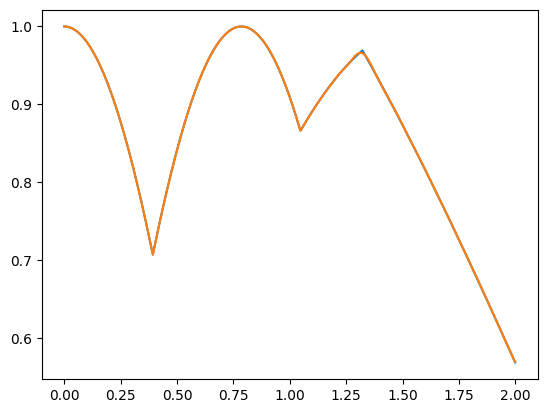

In [4]:
def estimate_coeffs(design_matrix, values) -> list[float]:
    X = design_matrix
    beta = np.linalg.inv(X.T @ X) @ X.T @ values # formula from minimising the least-squares error
    return beta.flatten().tolist()[0]

def points_approx(basis, sample_points: list, values: list[float], max_degree: int):
    indices = range(max_degree + 1)
    assert len(sample_points) >= len(indices)
    design_matrix = np.matrix([
        [basis(idx)(x) for idx in indices] for x in sample_points
    ])
    beta = estimate_coeffs(design_matrix, values)
    def approx(x):
        return sum(basis(idx)(x) * beta[i] for (i, idx) in enumerate(indices))
    return (approx, beta, design_matrix)

import math

def chebyshev_t(n: int, x: float):
    return math.cos(n * math.acos(x))


delta = 1e-1
matched_cusp_points = [0.38, 1.05]
c = matched_cusp_points[1] + delta
# from polyapprox.approx import points_approx
# from polyapprox.bases import chebyshev_t

def cheb_basis_shifted(n: int):
    return lambda x: chebyshev_t(n, 2*(x - c)/(b - c) - 1)

plt.plot(x_values, y3_values)

x_sample = []
y_sample = []
modified_indices = []
for i, (x, y) in enumerate(zip(x_values, y3_values)):
    if c <= x and x <= b:
        x_sample.append(x)
        y_sample.append(y)
        modified_indices.append(i)
    
(approx, _, _) = points_approx(cheb_basis_shifted, x_sample, y_sample, max_degree=20)
y_modified = [approx(x) for x in x_sample]
start = modified_indices[0]
for i in modified_indices:
    y3_values[i] = y_modified[i - start]

plt.plot(x_values, y3_values)


Isaac's method 1

In [5]:
# n = 50
# y1_values = y1_values ** n
# y2_values = y2_values ** n
# y3_values = y3_values ** n

Define a function as in Isaac's method 2

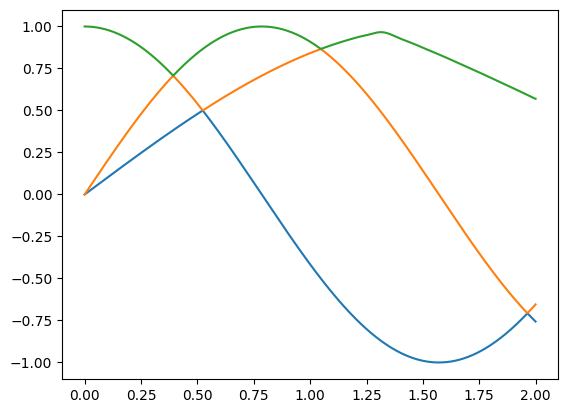

In [6]:
D = 3
n = 4
matched_cusp_points = [0.38, 1.05]
epsilon = 1e-1
c0 = a
b1 = matched_cusp_points[0] - epsilon
c1 = matched_cusp_points[0] + epsilon
b2 = matched_cusp_points[1] - epsilon
c2 = matched_cusp_points[1] + epsilon
b3 = b
def s(x):
    return D*(1 - np.sin(np.pi*x)**(2*n))

def transformer(x, y):
    if c0 <= x and x <= b1:
        return y + y**10
        return s((x - c0)/(b1 - c0) - 1/2) + y
    if b1 <= x and x <= c1:
        return y
    if c1 <= x and x <= b2:
        return y + y**10
        return s((x - c1)/(b2 - c1) - 1/2) + y
    if b2 <= x and x <= c2:
        return y
    if c2 <= x and x <= b3:
        return y + y**10
        return s((x - c2)/(b3 - c2) - 1/2) + y
    raise Exception("transformer domain error")

# y3_values = [transformer(x, y) for x, y in zip(x_values, y3_values)]

plt.plot(x_values, y1_values)
plt.plot(x_values, y2_values)
plt.plot(x_values, y3_values)

Next we compute the ESPs of this data with the top stack, i.e. `y4_values`, removed. We will be using traditional ESPs and the Frobenius companion matrix since it keeps things simple and mostly performs similarly.

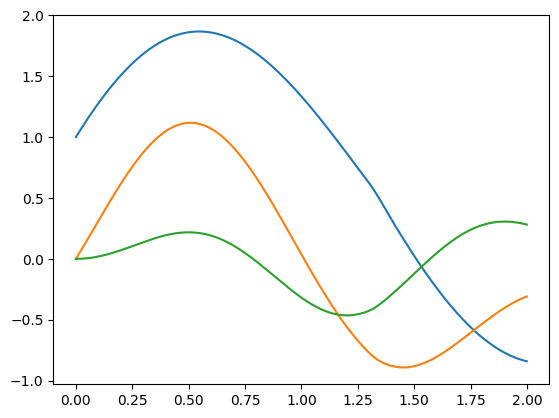

In [7]:
# Compute the ESPs
sum_curve = y1_values + y2_values + y3_values
mixed_curve = y1_values * y2_values + y1_values * y3_values + y2_values * y3_values
product_curve = y1_values * y2_values * y3_values

# plt.plot(x_values, y1_values)
# plt.plot(x_values, y2_values)
# plt.plot(x_values, y3_values)
plt.plot(x_values, sum_curve)
plt.plot(x_values, mixed_curve)
plt.plot(x_values, product_curve)

Since we use Chebyshev approximation at various points, let's set a consistent approximation degree for them here. Then we import e.g. chebfit from numpy to approximate the ESPs with.

In [8]:
degree = 45 # This degree is pretty high for a 1D problem, you can lower it to see how it fails worse and worse because of the unmatched cusp

from numpy.polynomial.chebyshev import chebfit as polyfit
from numpy.polynomial.chebyshev import chebval as polyval

coefficients_sum = polyfit(x_values, sum_curve, degree)
interpolated_sum_curve = polyval(x_values, coefficients_sum) # The interpolated things are stand-ins for what a ML model would in practice give us

coefficients_mixed = polyfit(x_values, mixed_curve, degree)
interpolated_mixed_curve = polyval(x_values, coefficients_mixed)

coefficients_product = polyfit(x_values, product_curve, degree)
interpolated_product_curve = polyval(x_values, coefficients_product)

/Users/isaac/maths/ace/code/.venv/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/Users/isaac/maths/ace/code/.venv/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/Users/isaac/maths/ace/code/.venv/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


Now we loop over our data, construct the companion matrix at each point and reconstruct the value-sorted stack.

Finally we can plot the original curves

In [9]:
points = [] # We could pre-allocate since the dimensions are known but for small problems efficiency isn't really a concern
for i, (s,p1,p2) in enumerate(zip(interpolated_sum_curve, interpolated_mixed_curve, interpolated_product_curve)):
    matrix = companion([1,-s,p1,-p2]) # scipy's Frobenius companion matrix implementation for simplicity
    roots = np.sort(np.linalg.eigvals(matrix))
    if abs(roots[0] - roots[1]) < 9e-3:
        print(x_values[i])
    if abs(roots[1] - roots[2]) < 9e-3:
        print(x_values[i])
    if abs(roots[0] - roots[2]) < 9e-3:
        print(x_values[i])
    points.append(roots)

points = np.array(points).T

0.38318589146965154
0.40644618217217454
0.5157753708664046
0.5158056540898797
0.5158832554303112
0.5162668654022551
0.5164887765979167
1.9614786871668588
1.9619747563253702
1.9622358157358715
1.9622874635836438
1.962355673524589
1.962372356054847
1.9623850583282316
1.9625941809944933
1.9730304975859594
1.9732602459176938
1.973279157002351
1.973325186534293
1.9737738732010346


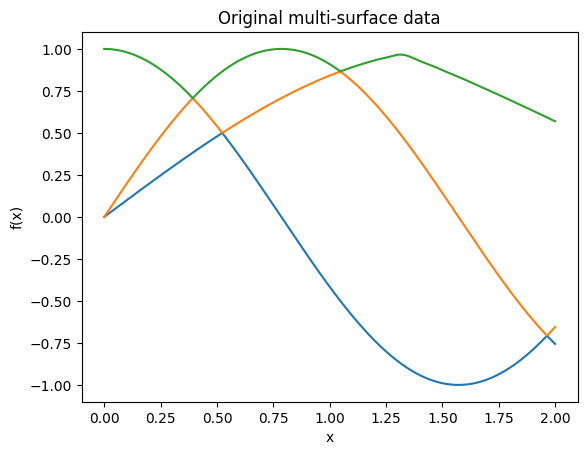

In [10]:
# Make the default color wheel accessible
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(0)
plt.plot(x_values, y1_values, color=colors[0])
plt.plot(x_values, y2_values, color=colors[1])
plt.plot(x_values, y3_values, color=colors[2])
# plt.plot(x_values, sorted_curves[3, :], color=colors[3], linewidth=4) # optionally plot the missing fourth stack
plt.title("Original multi-surface data")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

and the reconstructed ones

/Users/isaac/maths/ace/code/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/isaac/maths/ace/code/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


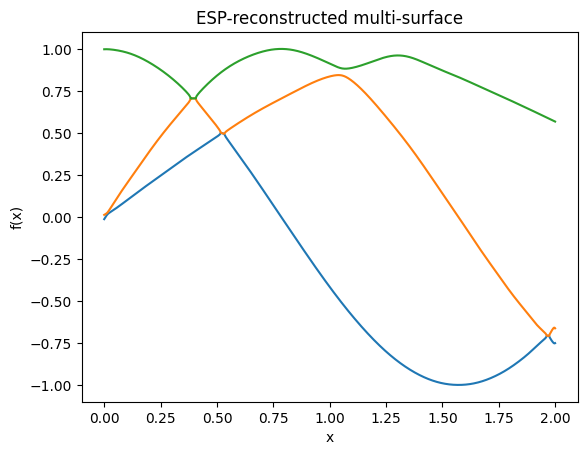

In [11]:
plt.figure(1)
plt.plot(x_values, points[0, :], color=colors[0])
plt.plot(x_values, points[1, :], color=colors[1])
plt.plot(x_values, points[2, :], color=colors[2])
plt.title("ESP-reconstructed multi-surface")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()